# Imports Libraries and Tools

In [7]:
import os  #untuk operasi sistem file
import numpy as np  #untukk menangani data gambar dalma bentuk array
import random  #untuk generating random values for augmentation
from PIL import Image, ImageEnhance  # untuk memproses gambar dan meningkatkan kualitas
from tensorflow.keras.preprocessing.image import load_img  #untuk memuat gmbar
from tensorflow.keras.models import Sequential  #untuk membangun model & menambahkan lapisan
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  #mendefinisikan lapisan
from tensorflow.keras.optimizers import Adam  #optimasi 
from tensorflow.keras.applications import VGG16  #untuk transfer learning imagenet
from sklearn.utils import shuffle  #untuk mengacak data agar tidk hafal
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.models import load_model, Model # type: ignore


# Load Datasets

In [8]:
#menentukan lokasi file training
train_dir = r"D:\Ara\Dataset\train"

#memuat data- latih
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_dir = r"D:\Ara\Dataset\valid"
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Image Preprocessing (Helper Functions)

In [9]:
#fungsi unutk mengaugmentasi
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  #kecerahan acak
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  #kontras acak
    image = np.array(image) / 255.0  #menormalisasi nilai pixel menjadi (o.1)
    return image

#mengmabil gambar
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# mengganti nama menjadi angka
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  #menentukann label unik di direktori
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

#datagen untuk mengambil tiap batch 
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  #membuka dan mengaugmentasi
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  #mengkodekan labelnya
            yield batch_images, batch_labels  #hasil satu batch

In [10]:
# Ukuran gambar
IMAGE_SIZE = 128
NUM_CLASSES = 6  # Jumlah jenis bunga kertas + non bunga kertas

# Load model VGG16 tanpa fully connected layers
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Membekukan semua layer VGG16 agar tidak dilatih ulang
for layer in base_model.layers:
    layer.trainable = False

# Mengaktifkan kembali 3 layer terakhir agar bisa dilatih
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Membangun model Sequential
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  # Layer Input
    base_model,  # VGG16 sebagai feature extractor
    Flatten(),  # Konversi fitur ke vektor 1D
    Dropout(0.3),  # Regularisasi untuk mencegah overfitting
    Dense(128, activation='relu'),  # Fully Connected Layer dengan ReLU
    Dropout(0.3),  # Dropout lagi untuk regularisasi
    Dense(NUM_CLASSES, activation='softmax')  # Output layer dengan softmax
])

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Menampilkan arsitektur model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,166 (60.14 MB)

 Trainable params: 8,128,902 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [11]:

# Load dan siapkan data validasi dari test
val_images = open_images(test_paths) 
val_labels = encode_label(test_labels) 

# Parameter
batch_size = 16
steps = int(len(train_paths) / batch_size) 
epochs = 3

# Fit model dengan data augmentasi
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps,
                    validation_data=(val_images, val_labels))

Epoch 1/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 65s 949ms/step - loss: 0.7853 - sparse_categorical_accuracy: 0.7115 - val_loss: 0.2140 - val_sparse_categorical_accuracy: 0.9250
Epoch 2/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 60s 897ms/step - loss: 0.0479 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.2935 - val_sparse_categorical_accuracy: 0.8850
Epoch 3/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 60s 897ms/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.0524 - val_sparse_categorical_accuracy: 0.9900


# Train and Val Plots

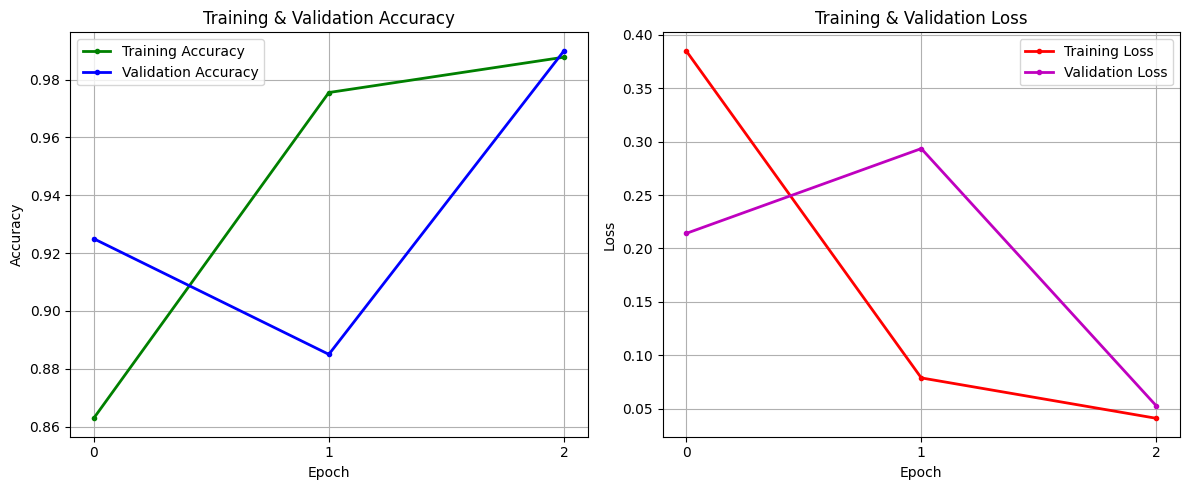

In [12]:
plt.figure(figsize=(12, 5))

# Subplot 1: Training & Validation Accuracy
plt.subplot(1, 2, 1)  
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2, label="Training Accuracy")
plt.plot(history.history['val_sparse_categorical_accuracy'], '.b-', linewidth=2, label="Validation Accuracy")
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(epochs))
plt.legend()
plt.grid(True)

# Subplot 2: Training & Validation Loss
plt.subplot(1, 2, 2)  
plt.grid(True)
plt.plot(history.history['loss'], '.r-', linewidth=2, label="Training Loss")
plt.plot(history.history['val_loss'], '.m-', linewidth=2, label="Validation Loss")
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(epochs))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Model Classification Report

In [13]:
# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 778ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.99      1.00      1.00       100
           2       1.00      0.95      0.97        20
           3       1.00      0.95      0.97        20
           4       1.00      1.00      1.00        20
           5       0.87      1.00      0.93        20

    accuracy                           0.98       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.98      0.98       200



# Model Confusion Plot

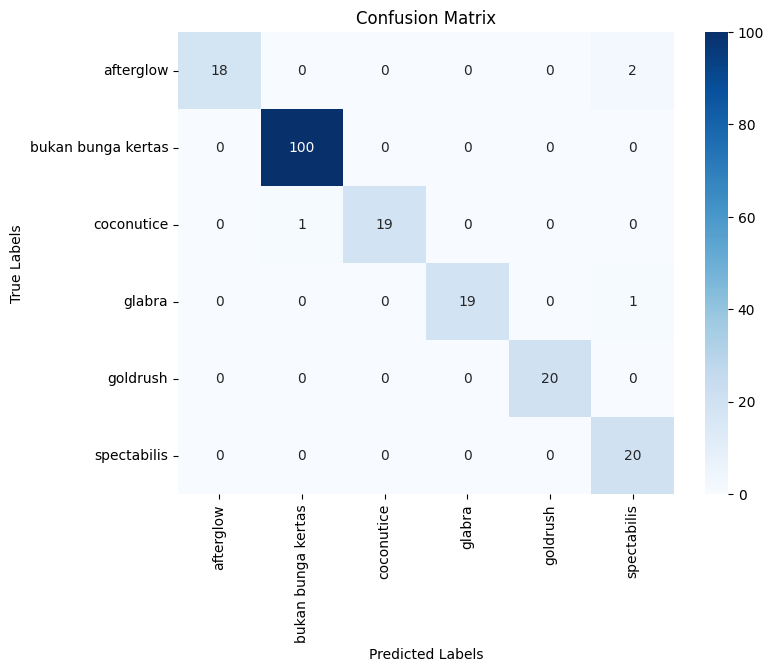

In [14]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Save & Load Model

In [18]:
# Save the entire model
model.save('model.h5')

In [ ]:
# Ambil urutan label dari direktori training agar sesuai dengan model
labels = os.listdir(train_dir)

# Fungsi preprocessing gambar (mengikuti pipeline training)
def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

threshold = 75

# Load dan preprocess gambar
img = load_and_preprocess_image(r'D:\Ara\Dataset\Valid\goldrush\IMG_20250513_171434.jpg')

# Prediksi model
predictions = model.predict(img)[0]

# Hitung persentase probabilitas
pred_percent = [float(p) * 100 for p in predictions]

# Dapatkan indeks prediksi tertinggi dan confidence-nya
max_index = np.argmax(predictions)
confidence = round(pred_percent[max_index], 2)

# Cek apakah confidence cukup tinggi
if confidence < threshold:
    hasil_klasifikasi = 'Bukan bunga kertas'
else:
    hasil_klasifikasi = labels[max_index]

# Cetak hasil
print("Hasil klasifikasi:", hasil_klasifikasi)
print("\nProbabilitas masing-masing kelas:")
for label, percent in zip(labels, pred_percent):
    print(f"- {label}: {percent:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Hasil klasifikasi: goldrush

Probabilitas masing-masing kelas:
- afterglow: 0.77%
- bukan bunga kertas: 0.25%
- coconutice: 0.01%
- glabra: 0.05%
- goldrush: 90.85%
- spectabilis: 8.06%
